# CS105 Final Project: Amazon Magazine Recommender System

## Project Proposal

We want to create an Amazon Item Recommender System that uses collaborative filtering. To start off, we would choose a random user from the reviews dataset and try to find its neighbors (other closest related users) using the k-NN algorithm.

Using collaborative filtering: given a user, find other similar users whose ratings strongly correlate with the current user

Goal: Starting with one initial user, find similar users (neighbors) who have about the same ratings on items. Then, recommend items to the initial user that they have not reviewed/purchased based on the similar users’ other reviews.

## Data Collection and Data Cleaning

Reading in and cleaning the data from http://deepyeti.ucsd.edu/jianmo/amazon/index.html

Cleaning needed to only include specific columns that are needed for EDA and collaborative filtering, further cleaning is done specific to each EDA instance and the collaborative filtering (ie. dropping unusable tuples like NaN or nonsense values, assimilating text data to each other, formatting, removing commas from integers to work with, etc).

In [1]:
import pandas as pd
df_magsubs = pd.read_json('Magazine_Subscriptions.json', lines=True)
df_metamagsubs = pd.read_json('meta_Magazine_Subscriptions.json', lines=True)

df_magsubs.to_csv()
df_magsubs
df_magsubs = df_magsubs[["overall", "vote", "verified", "reviewerID", "asin", "reviewerName", "reviewText", "summary"]]
df_magsubs.dropna(subset=["overall", "vote", "verified", "reviewerID", "asin", "reviewerName", "reviewText", "summary"], inplace=True)
df_magsubs.reset_index()
df_magsubs


,overall,vote,verified,reviewerID,asin,reviewerName,reviewText,summary
0,5,9,False,AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME"
1,5,9,False,AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop
2,3,14,False,A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone"
3,5,13,False,A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER
24,4,2,False,A3VGQU7L9OUI53,B00005N7P0,Creative Sponge,I am a little disappointed I am unable to purc...,Max PC is no longer available for purchase on ...
...,...,...,...,...,...,...,...,...
89554,5,2,False,A2PGNALRV46Q5I,B01FGEQZ4O,Pollys Pockets,"Maybe more on the modern side, Love the color ...",Patchwork
89558,5,3,True,A29ZW8DP4KBPWO,B01FKX9UI4,Kim Becker,My favorite magazine. Fun and informative arti...,Very good!
89559,5,3,True,ACN69332V2ZUU,B01FKX9UI4,Raven1272007,It's good eas to read\ny\neSy,Five Stars
89560,1,4,True,A39I2UDNZ9P8PJ,B01FKX9UI4,Pet Lover,It never down loaded to the kindle,Problem


## EDA

### Magazine Genres

It is important in any situation to know what kind of data is being worked on. There were a large variety of magazines Amazon sold at the time of this data collection, and the most abundant magazine genres are listed below. No one specific genre dominates the distribution of magazine types, but the most prevelant magazines available are professional and educational journals.

In [2]:
df_categories = df_metamagsubs.category
#series_categories.dropna()
df_categories.str.split(pat=",")
df_categories.apply(pd.Series).stack()
df_categories = df_categories.explode('Category')
df_categories = df_categories.to_frame()
df_categories = df_categories[df_categories.category != "Magazine Subscriptions"]
df_categories = df_categories.dropna()
df_categories = df_categories.replace("amp;", "", regex=True)
df_CatCount = df_categories.value_counts().to_frame('amount')
df_CatCount.reset_index(inplace=True)
other = df_CatCount.loc[25:].amount.sum()  
df_CatCount = df_CatCount.loc[:25] 
df_CatCount.loc[len(df_CatCount.index)] = ['Other', other]
df_CatCount

,category,amount
0,Professional & Educational Journals,865
1,Professional & Trade,856
2,"Sports, Recreation & Outdoors",355
3,Sports & Leisure,344
4,"Travel, City & Regional",281
5,Humanities & Social Sciences,279
6,United States,244
7,Arts,195
8,Fashion & Style,148
9,Home & Garden,135


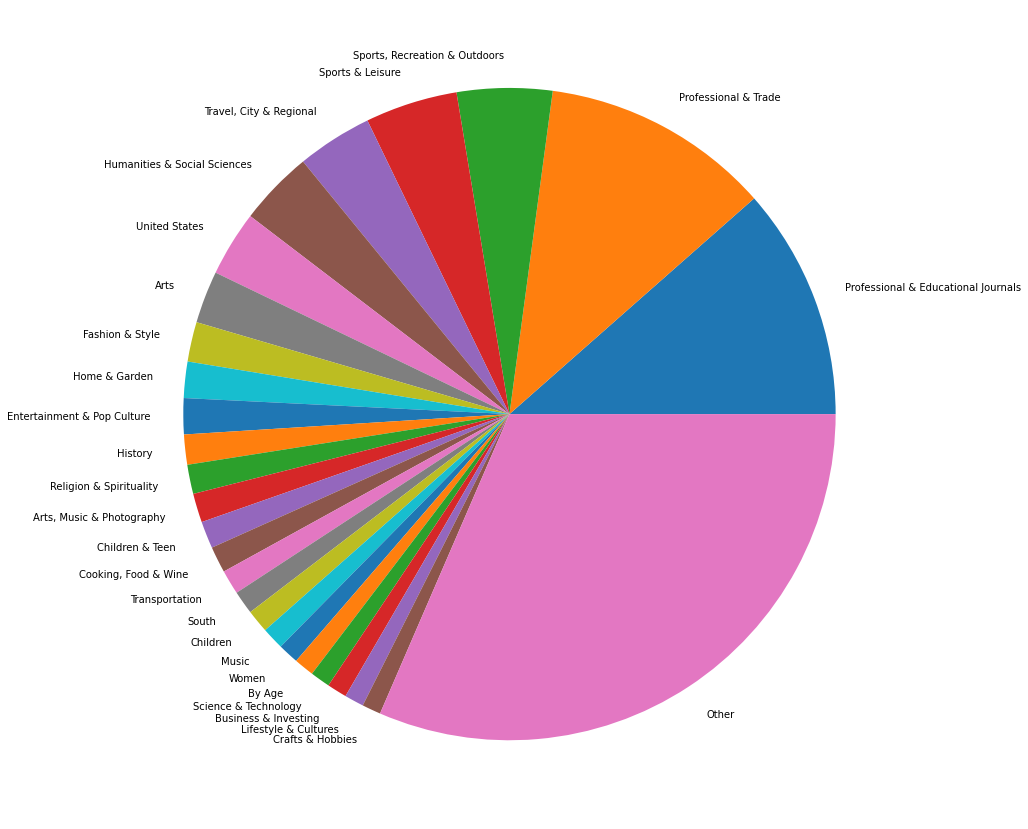

In [3]:
import matplotlib.pyplot as plt

plt.pie(df_CatCount.amount, labels = df_CatCount.category)
fig = plt.gcf()
fig.set_size_inches(15,15)
#fig.show()

### Verified vs Unverified Users

In [4]:
import numpy as np
print("Average ratings of reviews between Verified vs Unverified Users")
df_rev = df_magsubs.pivot_table(values=["overall"], index=["asin"], columns = ["verified"], aggfunc = np.mean)

df_rev.dropna(inplace=True)

df_rev

Average ratings of reviews between Verified vs Unverified Users


overall          
verified       False      True
asin                          
B00005N7NQ  3.619048  3.791667
B00005N7O6  4.500000  4.600000
B00005N7OA  3.142857  5.000000
B00005N7OC  2.333333  2.000000
B00005N7OD  3.321429  2.900000
...              ...       ...
B01DT6OMB4  1.000000  5.000000
B01DT6PL46  1.000000  1.666667
B01DWVLMJG  5.000000  5.000000
B01F2MKW0I  3.500000  4.652174
B01HI8V1I6  4.500000  5.000000

[980 rows x 2 columns]

In [5]:
df = df_magsubs.groupby("verified")["overall"].mean()
df

verified
False    3.241238
True     3.513430
Name: overall, dtype: float64

<AxesSubplot:xlabel='verified'>

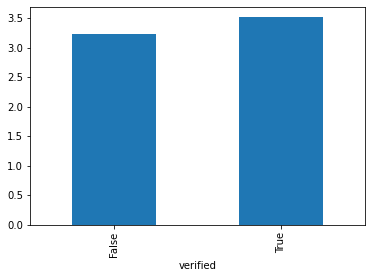

In [6]:
df.plot.bar()

### Bag of Words Reviews

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None
import string
df = pd.read_json("Magazine_Subscriptions.json", lines=True)
df.to_csv()
df["asin"] = df["asin"].apply(str)
df['reviewText'] = df['reviewText'].str.lower()
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]','',regex=True)
df['reviewText'] = df['reviewText'].fillna("NoReview")
df_reviews = df[["reviewerID","asin","reviewText"]]
df_reviews.head()

,reviewerID,asin,reviewText
0,AH2IFH762VY5U,B00005N7P0,for computer enthusiast maxpc is a welcome sig...
1,AOSFI0JEYU4XM,B00005N7P0,thank god this is not a ziff davis publication...
2,A3JPFWKS83R49V,B00005N7OJ,antiques magazine is a publication made for an...
3,A19FKU6JZQ2ECJ,B00005N7OJ,this beautiful magazine is in itself a work of...
4,A25MDGOMZ2GALN,B00005N7P0,a great read every issue


In [8]:
reviewCounts = pd.Series([y for x in df_reviews.values.flatten() for y in x.split()]).value_counts()
reviewCounts.head(50)

the             174797
i               121482
and             115459
to              108471
a                93202
of               75283
it               70257
magazine         67653
is               60526
for              59388
this             55926
in               45258
that             39275
my               39237
on               31389
have             29855
you              28464
not              27018
are              26845
but              25317
with             25273
great            22966
as               22173
was              20719
articles         17815
they             17512
be               17410
love             16717
like             16553
subscription     16260
read             16061
its              15940
so               15919
good             15408
all              14830
issue            14541
about            14455
or               14078
one              14023
has              13600
if               13288
me               12726
more             12559
at         

The words most used in reviews were common words such as "the", "I", "and", "to". The words "magazine" and "subscription" appeared quite often due to the subject of our study. It also influenced words such as "read","issue", "articles" since magazines are an issue of articles that are being read. Based on the top words alone, it seems that most people have positive reviews on the magazines since there aren't many negative connotated words while the positive ones being somewhat common ("good", "great").

In [9]:
input = "This magazine is great, and the stories are very interesting."
input = input.lower()
input = input.translate(str.maketrans('', '', string.punctuation))
input

'this magazine is great and the stories are very interesting'

This will be the input review that we will be testing for the highest cosine similarity.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
df_Sim = df_reviews
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Vincent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
input_set = set(word_tokenize(input))
df_Sim['tokenReview'] = df_Sim['reviewText'].apply(word_tokenize).apply(set) 
df_Sim.head()

,reviewerID,asin,reviewText,tokenReview
0,AH2IFH762VY5U,B00005N7P0,for computer enthusiast maxpc is a welcome sig...,"{computer, only, own, consider, maxpc, cdand, ..."
1,AOSFI0JEYU4XM,B00005N7P0,thank god this is not a ziff davis publication...,"{tell, maxpc, not, product, god, i, this, thei..."
2,A3JPFWKS83R49V,B00005N7OJ,antiques magazine is a publication made for an...,"{read, consider, its, historical, glimpse, alo..."
3,A19FKU6JZQ2ECJ,B00005N7OJ,this beautiful magazine is in itself a work of...,"{read, every, my, including, years, quality, b..."
4,A25MDGOMZ2GALN,B00005N7P0,a great read every issue,"{read, every, issue, a, great}"


In [12]:
df_Sim['Similarity'] = 0
for index, row in df_Sim.iterrows():
    currVector = input_set.union(row['tokenReview'])
    l1 =[];l2 =[]
    for w in currVector:
        if w in input_set: l1.append(1)
        else: l1.append(0)
        if w in row['tokenReview']: l2.append(1)
        else: l2.append(0)
    c = 0
    for i in range(len(currVector)):
        c+= l1[i]*l2[i]
    if sum(l2) == 0:
        df_Sim.loc[index, 'Similarity'] = 0
    else:
        df_Sim.loc[index, 'Similarity'] = c / float((sum(l1)*sum(l2))**0.5)
df_Sim.head()

,reviewerID,asin,reviewText,tokenReview,Similarity
0,AH2IFH762VY5U,B00005N7P0,for computer enthusiast maxpc is a welcome sig...,"{computer, only, own, consider, maxpc, cdand, ...",0.146176
1,AOSFI0JEYU4XM,B00005N7P0,thank god this is not a ziff davis publication...,"{tell, maxpc, not, product, god, i, this, thei...",0.144673
2,A3JPFWKS83R49V,B00005N7OJ,antiques magazine is a publication made for an...,"{read, consider, its, historical, glimpse, alo...",0.178885
3,A19FKU6JZQ2ECJ,B00005N7OJ,this beautiful magazine is in itself a work of...,"{read, every, my, including, years, quality, b...",0.300000
4,A25MDGOMZ2GALN,B00005N7P0,a great read every issue,"{read, every, issue, a, great}",0.141421


In [13]:
df_Sim.sort_values(by=['Similarity'], ascending=False)

,reviewerID,asin,reviewText,tokenReview,Similarity
73095,A186HTO2DI1809,B00YQH9856,this magazine is very interesting and informative,"{interesting, and, this, informative, is, maga...",0.717137
15372,A1IBJDINIBX9EY,B00005N7QG,love this magazine and the price is great,"{the, price, love, and, this, is, great, magaz...",0.670820
37269,A3TWWC2B55AGVR,B00007B10Y,wonderful magazine and very great stories,"{stories, and, great, magazine, very, wonderful}",0.645497
81565,A3KVMN9OTVVUJR,B000BYD9V2,great magazine very interesting and informative,"{interesting, and, informative, great, magazin...",0.645497
67029,A3RO06TXVLAJU5,B005DNA3LU,the magazine is colorful and interesting,"{the, interesting, and, is, magazine, colorful}",0.645497
...,...,...,...,...,...
80244,A23QGG90CNKFRP,B00008WETF,as advertised,"{advertised, as}",0.000000
62525,AQTAZTY0T3LIF,B001C4Q06G,i have yet to receive an issue,"{an, issue, have, i, receive, to, yet}",0.000000
62526,A2E0P8AUHQOSGR,B001C4Q06G,thanks,{thanks},0.000000
35809,A1L5PVBLJJME7V,B00007B10Y,always enjoy,"{always, enjoy}",0.000000


Based off the cosine similarity analysis on our bag of words model, the top result with a similarity of 0.717 shows the reviewerID and the text they wrote, which is in fact similar to our input review.

# The Main Part: 
## Collaborative Filtering

Here we use collaborative filtering to build a recommender system based on reviews given by customers. Given a set of ratings that determine what a user things about certain magazines, our recommender system recommends certain other magazines the user has not read based on how similar their existing preferences are to other users who have data in our system on the assumption that similar people like similar things. The existence of the dataset online eliminates the cold start and first rater problems that come with collaborative filtering.

In [14]:
dfNumReviewers = df_magsubs.groupby('asin').size().to_frame('amount')
dfNumReviewers.reset_index(inplace=True)
dfNumReviewers.sort_values(by=['amount'], ascending=False)

,asin,amount
893,B00077B7M6,481
125,B00005NIOH,345
215,B000063XJL,291
679,B00007BK3L,248
1122,B0012C1O8C,240
...,...,...
1320,B009CWB3ZS,1
815,B0000CCYDL,1
384,B00006KKAI,1
382,B00006KJP6,1


In [15]:
from scipy.sparse import csr_matrix
userInput = [ 
    {'asin':'B00077B7M6', 'overall':5},
    {'asin':'B00005NIOH', 'overall':3},
     {'asin':'B000063XJL', 'overall':4},
     {'asin':'B00007BK3L', 'overall':2}, 
    ]
inputMag = pd.DataFrame(userInput)
inputMag

,asin,overall
0,B00077B7M6,5
1,B00005NIOH,3
2,B000063XJL,4
3,B00007BK3L,2


In [16]:
userSubset = df_magsubs[df_magsubs['asin'].isin(inputMag['asin'].tolist())]
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(userSubset)
userSubset

,overall,vote,verified,reviewerID,asin,reviewerName,reviewText,summary
16821,5,2,False,A2LWLWMA53BHW6,B00005NIOH,Hathor,The National Geographic Magazine is one of the...,One of the Best magazine
16822,5,3,False,A1LDBSN0U8D5F6,B00005NIOH,Eli Lesser-goldsmith,By far the best photographic magazine on the p...,One of the best!
16823,5,2,False,A1GDO7BM18TLCZ,B00005NIOH,Lintasare,This is my favorite magazine in the world. I ...,Wonderful
16824,5,25,False,A2YXR3FXYAIK8C,B00005NIOH,Steve Duda,Is it safe to say that National Geographic is ...,the greatest?
16826,5,8,False,A26I6INR134CML,B00005NIOH,M. O&#039;Neil,It's strange--I would never consider saving an...,A Definite Keeper
...,...,...,...,...,...,...,...,...
44306,5,86,False,A2VODABWSVHV8E,B00077B7M6,Ray,I subscribed to The Economist over a year ago ...,A Truly Outstanding Magazine
44307,5,10,False,AVQ4CY0QZDVBR,B00077B7M6,TDM,The Economist is the best newspaper (as it cal...,"An in-depth, brilliantly and fairly written su..."
44308,5,101,False,A13MSJWB3IXGV4,B00077B7M6,Anonymous,Bill Gates once said in an interview that he r...,The Best Magazine In The World
44309,5,8,False,A3KNDQ98179AHY,B00077B7M6,Samuel Sonne,I admire The Economist for its focus on its su...,Economics at its best


In [17]:
userSubGroup = userSubset.groupby(['reviewerID'])
#userSubset.sort_values(by=['reviewerID'], ascending=False)
userSubGroup.get_group('AVF9FV7AMRP5C')#why this reviewerID?

,overall,vote,verified,reviewerID,asin,reviewerName,reviewText,summary
22543,5,3,False,AVF9FV7AMRP5C,B00005NIOH,X. Liu,"In an era of declining journalism, National Ge...",Wonderful reporting and feature articles from ...
38855,4,5,True,AVF9FV7AMRP5C,B00007BK3L,X. Liu,Time magazine does a good job providing a gene...,"Time is a decent weekly, you get what you pay for"


In [18]:
userSubGroup = sorted(userSubGroup,  key=lambda x: len(x[1]), reverse=True)
#userSubGroup
len(userSubGroup)# number of reviews of the 4 user-picked magazines, sorted in groups by reviewer descending by how many of the magazines 
                    #users reviewed among the 4 (highest rn is 2 at the same time)

1351

In [19]:
import scipy.stats as sp
pearsonCorrelation= {}

for reviewerID, group in userSubGroup:
    group = group.sort_values(by='asin')
    inputMag = inputMag.sort_values(by='asin')

    nRatings = len(group)
    
    temp_df = inputMag[inputMag['asin'].isin(group['asin'].tolist())]
    
    tempRateList = temp_df['overall'].tolist()
    tempGroupList = group['overall'].tolist()
    
    #tempRateList
    #tempGroupList
    #sp.stats.pearsonr(tempRateList,tempGroupList)[0] #doesn't work if corresponding reviewer only has watched 1 of the shows on the list
    #print(tempRateList, pow(sum(tempRateList),2))
    Sxx = sum([i**2 for i in tempRateList]) - pow(sum(tempRateList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRateList, tempGroupList)) - sum(tempRateList)*sum(tempGroupList)/float(nRatings)
    if Sxx != 0 and Syy != 0:
        pearsonCorrelation[reviewerID] = Sxy/np.sqrt(Sxx*Syy)
    else:
        pearsonCorrelation[reviewerID] = 0

In [20]:
#pearsonCorrelation.items()

In [21]:
#nRatings

In [22]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelation, orient='index')
pearsonDF.head()

,0
A1AB6D301MOTM0,1.0
A1DMJHAM09Z8GU,0.0
A1EMDSTJDUE6B0,0.0
A1YLT3O53D5F86,0.0
A20A5C9M1R0MV3,0.0


In [23]:
pearsonDF.columns = ['similarityIndex']
pearsonDF['reviewerID'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,reviewerID
0,1.0,A1AB6D301MOTM0
1,0.0,A1DMJHAM09Z8GU
2,0.0,A1EMDSTJDUE6B0
3,0.0,A1YLT3O53D5F86
4,0.0,A20A5C9M1R0MV3


In [24]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,reviewerID
0,1.0,A1AB6D301MOTM0
7,1.0,A3BO1VM9CSCWW1
13,1.0,AVF9FV7AMRP5C
899,0.0,A3ICZCZWX1GXHM
907,0.0,A3IWLY937LOBPZ


## Collaborative Filtering
Insert description here.

In [25]:
import pandas as pd
import numpy as np
# ALL RATINGS FOR ALL MAGAZINES 
df_magsubs = pd.read_json('Magazine_Subscriptions.json', lines=True)
df_ratings = df_magsubs[["overall", "reviewerID", "asin"]]
df_ratings

,overall,reviewerID,asin
0,5,AH2IFH762VY5U,B00005N7P0
1,5,AOSFI0JEYU4XM,B00005N7P0
2,3,A3JPFWKS83R49V,B00005N7OJ
3,5,A19FKU6JZQ2ECJ,B00005N7OJ
4,5,A25MDGOMZ2GALN,B00005N7P0
...,...,...,...
89684,5,AB5HCI50SF1TK,B01HI8V1C2
89685,1,A2X11NZMPI7M0T,B01HI8V1C2
89686,5,A3EGFFBRQVO7L7,B01HI8V1C2
89687,5,A3H23AVKFN62ZT,B01HIZSSQM


In [26]:
# ALL MAGAZINES AND THEIR GENRE 
df_metamagsubs = pd.read_json('meta_Magazine_Subscriptions.json', lines=True)
df_metamagsubs = df_metamagsubs[["asin", "category"]]
# indexNames = df_metamagsubs[df_metamagsubs['category'] == '[]' ].index
# df_metamagsubs = df_metamagsubs.drop(indexNames , inplace=True)

df_metamagsubs

,asin,category
0,B00005N7NQ,"[Magazine Subscriptions, Professional & Educat..."
1,B00005N7OC,"[Magazine Subscriptions, Arts, Music &amp; Pho..."
2,B00005N7OD,"[Magazine Subscriptions, Fashion &amp; Style, ..."
3,B00005N7O9,"[Magazine Subscriptions, Sports, Recreation & ..."
4,B00005N7O6,"[Magazine Subscriptions, Professional & Educat..."
...,...,...
3380,B01HI8V19K,[]
3381,B01HI8V1I6,"[Magazine Subscriptions, Sports, Recreation & ..."
3382,B01HI8V0ZK,"[Magazine Subscriptions, Fashion & Style]"
3383,B01HI8V1C2,[]


In [27]:
df_metamagsubs = df_metamagsubs.loc[df_metamagsubs.astype(str).drop_duplicates().index]
df_metamagsubs

,asin,category
0,B00005N7NQ,"[Magazine Subscriptions, Professional & Educat..."
1,B00005N7OC,"[Magazine Subscriptions, Arts, Music &amp; Pho..."
2,B00005N7OD,"[Magazine Subscriptions, Fashion &amp; Style, ..."
3,B00005N7O9,"[Magazine Subscriptions, Sports, Recreation & ..."
4,B00005N7O6,"[Magazine Subscriptions, Professional & Educat..."
...,...,...
3380,B01HI8V19K,[]
3381,B01HI8V1I6,"[Magazine Subscriptions, Sports, Recreation & ..."
3382,B01HI8V0ZK,"[Magazine Subscriptions, Fashion & Style]"
3383,B01HI8V1C2,[]


In [28]:
# BREAKING UP ALL THE GENRES AND COUNTING THEM WITH 1 OR 0
magGenres = df_metamagsubs.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in df_metamagsubs.iterrows():
    for genre in row['category']:
        magGenres.at[index, genre] = 1
        
#Filling in the NaN values with 0 to show that a magazine doesn't have that column's genre
magGenres = magGenres.fillna(0)
magGenres.drop(['Magazine Subscriptions'], axis = 1, inplace=True)
magGenres.drop(['category'], axis = 1, inplace=True)
magGenres.head()

/Users/Vincent/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


,asin,Professional & Educational Journals,Professional & Trade,Humanities & Social Sciences,Economics & Economic Theory,"Arts, Music &amp; Photography",Music,Fashion &amp; Style,Women,"Sports, Recreation & Outdoors",...,Racket Sports,Spanish-Language,Interior Design,Country Life,Alternative & Holistic,Girls,Mathematics,Animals,Agricultural Sciences,Soccer
0,B00005N7NQ,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B00005N7OC,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B00005N7OD,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B00005N7O9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,B00005N7O6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
# USER WE ARE RECOMMENDING TO 
from scipy.sparse import csr_matrix
userInput = [ 
    #outdoor/sport test
    {'asin':'B00005N7OP', 'overall':1},
    {'asin':'B00005N7OC', 'overall':1},
    {'asin':'B00005N7UG', 'overall':5},
    {'asin':'B00005N7Q5', 'overall':5},
    {'asin':'B00005N7S2', 'overall':5},
    {'asin':'B00005N7O9', 'overall': 5},
    {'asin':'B00005N7RD', 'overall': 5},
    #original test
    #{'asin':'B00005N7P0', 'overall':1},
    #{'asin':'B00005N7OJ', 'overall':3},
    #{'asin':'B000063XJL', 'overall':1},
    #{'asin':'B00005N7PS', 'overall':4},
    #{'asin':'B00005N7NQ', 'overall': 2},
    #{'asin':'B00005N7QS', 'overall': 5},
    #{'asin':'B00005N7OU', 'overall': 4},
    #{'asin':'B00005N7RD', 'overall': 5},
    #{'asin':'B00D8GWHYK', 'overall': 3},
]
inputMags = pd.DataFrame(userInput)
inputMags

,asin,overall
0,B00005N7OP,1
1,B00005N7OC,1
2,B00005N7UG,5
3,B00005N7Q5,5
4,B00005N7S2,5
5,B00005N7O9,5
6,B00005N7RD,5


In [182]:
userMags = magGenres[magGenres['asin'].isin(inputMags['asin'].tolist())]
userMags

,asin,Professional & Educational Journals,Professional & Trade,Humanities & Social Sciences,Economics & Economic Theory,"Arts, Music &amp; Photography",Music,Fashion &amp; Style,Women,"Sports, Recreation & Outdoors",...,Racket Sports,Spanish-Language,Interior Design,Country Life,Alternative & Holistic,Girls,Mathematics,Animals,Agricultural Sciences,Soccer
1,B00005N7OC,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B00005N7O9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,B00005N7OP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,B00005N7Q5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,B00005N7S2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,B00005N7RD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,B00005N7UG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
userMags = userMags.reset_index(drop=True)

#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMags.drop(['asin'], axis = 1)
userGenreTable

,Professional & Educational Journals,Professional & Trade,Humanities & Social Sciences,Economics & Economic Theory,"Arts, Music &amp; Photography",Music,Fashion &amp; Style,Women,"Sports, Recreation & Outdoors",Sports & Leisure,...,Racket Sports,Spanish-Language,Interior Design,Country Life,Alternative & Holistic,Girls,Mathematics,Animals,Agricultural Sciences,Soccer
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
userProfile = userGenreTable.transpose().dot(inputMags['overall'])

#The user profile
userProfile.head(50)

Professional & Educational Journals         0.0
Professional & Trade                        0.0
Humanities & Social Sciences                0.0
Economics & Economic Theory                 0.0
Arts, Music &amp; Photography               1.0
Music                                       1.0
Fashion &amp; Style                         0.0
Women                                       0.0
Sports, Recreation & Outdoors              16.0
Sports & Leisure                           16.0
Flying                                      1.0
Transportation                              0.0
Technology                                  0.0
Computers &amp; Internet                    0.0
Cooking, Food & Wine                        0.0
Recipes & Techniques                        0.0
Professional &amp; Educational Journals     0.0
Professional &amp; Trade                    0.0
Medicine                                    0.0
Arts, Music & Photography                   5.0
Art & Art History                       

In [185]:
genreTable = magGenres.set_index(magGenres['asin'])
for index, row in userMags.iterrows():
    genreTable = genreTable[genreTable.asin != row.asin]
genreTable.drop(['asin'], axis = 1, inplace=True)
genreTable

,Professional & Educational Journals,Professional & Trade,Humanities & Social Sciences,Economics & Economic Theory,"Arts, Music &amp; Photography",Music,Fashion &amp; Style,Women,"Sports, Recreation & Outdoors",Sports & Leisure,...,Racket Sports,Spanish-Language,Interior Design,Country Life,Alternative & Holistic,Girls,Mathematics,Animals,Agricultural Sciences,Soccer
asin,,,,,,,,,,,,,,,,,,,,,
B00005N7NQ,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005N7OD,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005N7O6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005N7P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005N7QG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01HI8V19K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B01HI8V1I6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B01HI8V0ZK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
genreTable.shape

(2313, 226)

In [187]:
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

asin
B00005N7NQ    0.0
B00005N7OD    0.0
B00005N7O6    0.0
B00005N7P0    0.0
B00005N7QG    0.0
dtype: float64

In [188]:
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)

#Just a peek at the values
recommendationTable_df.head()

asin
B000BW56WO    0.493333
B00007KZ2V    0.493333
B019T6NB9M    0.493333
B00005NINW    0.493333
B00008CQGO    0.493333
dtype: float64

In [178]:
df_metamagsubs.loc[df_metamagsubs['asin'].isin(recommendationTable_df.head().keys())]

,asin,category
388,B00006K6FV,"[Magazine Subscriptions, Children & Teen, Chil..."
523,B00006KPSW,"[Magazine Subscriptions, Children & Teen, Chil..."
673,B000071FIR,"[Magazine Subscriptions, Children & Teen, Chil..."
771,B00007AXWU,"[Magazine Subscriptions, Children & Teen, Chil..."
2324,B000ILYKOS,"[Magazine Subscriptions, Children & Teen, Chil..."
